In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

The flow properties are:

In [74]:
U = 0.5             # m/s
fr = 10*60*0.001    # m3/s
fs = 13.39*1000     # Hz
tr = 0.007          # s

L = 1               # m
mu_c = 1*10**-3     # Pa s
rho_c = 1*10**3     # kg/m3

The bubble properties are:

In [ ]:
Ub = 1.2 * U       # m/s
rho_a = 1.293      # kg/m3 (@ 20°C)

The Reynolds number is given by $$\mathrm{Re} = \frac{\rho_c U L}{\mu},$$ where $\mu$ is the viscosity of water (at room temperature, approximately equal to $1\times 10^{-6} \text{m}^2/\text{s}$).

In [ ]:
Re = rho_c * U * L / mu_c
print(Re)

The Morton number is given by $$\mathrm{Mo}=\frac{g \mu_c^4 \Delta\rho}{\rho_c^2 \sigma^3}$$

In [ ]:
g = 9.81              # m/s2
# N/m (https://www.nanoscience.com/techniques/tensiometry/surface-and-interfacial-tension/)
sigma = 72.8 * 10**-3

Mo = g * mu_c**4 * (rho_c - rho_a) / (rho_c**2 * sigma**3)
print(np.log10(Mo))

Finally, the Bond (or Eötvös) number is $$\mathrm{Bo} = \frac{\Delta\rho g L^2}{\sigma}$$

In [ ]:
Bo = (rho_c - rho_a) * g * L**2 / sigma

print(Bo)

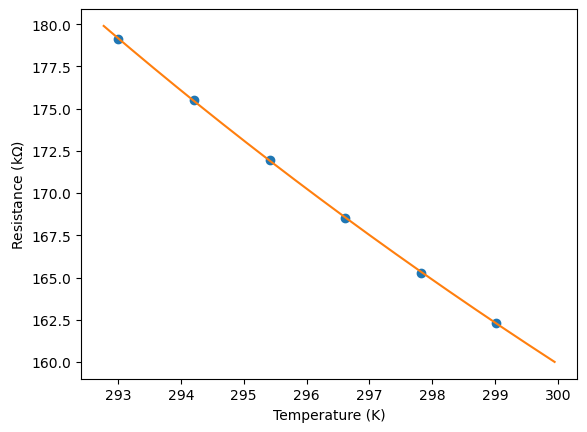

In [2]:
# Import ThermExperCalib.csv
[T_cal, R_cal] = np.squeeze(
    np.split(np.loadtxt('Data/ThermExperCalib.csv', delimiter=','), 2, axis=1))

# Plot the data
plt.plot(T_cal, R_cal/1000, 'o')
plt.xlabel('Temperature (K)')
plt.ylabel('Resistance (k$\Omega$)')

# Fit the Steinhart-Hart equation to the datapoints


def steinhart_hart(R, A, B, C):
    T_inv = A + B * np.log(R) + C * (np.log(R)**3)
    return T_inv


def calc_temp(R, A, B, C):
    T = 1/steinhart_hart(R, A, B, C)
    return T


[A, B, C] = curve_fit(steinhart_hart, R_cal, 1/T_cal)[0]


R_test = np.arange(160000, 180000, 100)
plt.plot(calc_temp(R_test, A, B, C), R_test/1000)
plt.show()

### 1c2) **Mean, standard error and PDF**
We start by importing the data, and calculating the temperature using the function defined in the previous section. We can directly obtain the mean and standard deviation of the signals.

In [72]:
# Import data
R_bub = np.loadtxt('Data/ThermBubData.csv', delimiter=',')
R_nobub = np.loadtxt('Data/ThermNoBubData.csv', delimiter=',')

# Calculate temperature
T_bub = calc_temp(R_bub, A, B, C)
T_nobub = calc_temp(R_nobub, A, B, C)

# Calculate and print statistics
T_mean_bub, T_std_bub = [np.mean(T_bub), np.std(T_bub)]
T_mean_nobub, T_std_nobub = [np.mean(T_nobub), np.std(T_nobub)]

print('Mean temperature (+- std) with bubbles: {:.3f} +- {:.3f}'.format(
    T_mean_bub, T_std_bub)
    + '\n                       without bubbles: {:.3f} +- {:.3f}'.format(
        T_mean_nobub, T_std_nobub))


Mean temperature (+- std) with bubbles: 295.796 +- 0.032
                       without bubbles: 295.810 +- 0.035


Next, we calculate the PDFs, centre the bins that were output by the `np.histogram` function, and plot the results.

The number of bins that will be used is based on #TODO Explain reasoning.

In [ ]:
# Calculate the probabiliy density function of the data
n_bins = 40

pdf_bub, bins_bub = np.histogram(T_bub, bins=n_bins, density=True)
bin_centers_bub = 0.5*(bins_bub[1:] + bins_bub[:-1])

pdf_nobub, bins_nobub = np.histogram(T_nobub, bins=n_bins, density=True)
bin_centers_nobub = 0.5*(bins_nobub[1:] + bins_nobub[:-1])

plt.plot(bin_centers_bub, pdf_bub, '.-', label='With bubbles')
plt.plot(bin_centers_nobub, pdf_nobub, '.-', label='Without bubbles')
plt.xlim([295.7, 295.95])
plt.legend()
plt.title('Temperature probability')
plt.xlabel('Temperature (K)')
plt.ylabel('Probability density (K$^{-1}$)')
plt.show()

We can check whether these PDFs are properly normalised: the probability of having *any* temperature should be equal to $100\%$, so $\int^{\infty}_{-\infty} PDF(x) \mathrm{d}x=1$.

In [71]:
print('The total probabilities of the above pdfs are '
      + str(np.sum(pdf_bub * (bins_bub[1] - bins_bub[0]))) + ' and '
      + str(np.sum(pdf_nobub * (bins_nobub[1] - bins_nobub[0]))) + ', respectively.')

The total probabilities of the above pdfs are 0.9999999999980371 and 0.9999999999975694, respectively.


### 1c3) **Power spectra**

In [75]:
# Calculate the power spectral density using the fast fourier transform
n = len(R_bub)
k = np.arange(n)
T = n/fs
frq = k/T
frq = frq[range(n//2)]

Y_bub = np.fft.fft(R_bub)/n
Y_bub = Y_bub[range(n//2)]

Y_nobub = np.fft.fft(R_nobub)/n
Y_nobub = Y_nobub[range(n//2)]
